# NLP'ye Giriş

Doğal dil işlemenin (NLP) temel amacı, doğal dilden bilgi elde etmektir. Doğal dil geniş bir terimdir ancak aşağıdakilerden herhangi birini kapsadığını düşünebilirsiniz:

- Metin (bir e-postada, blog gönderisinde, kitapta, Tweette bulunanlar gibi)
- Konuşma (bir doktorla yaptığınız konuşma, telefonuna verdiğiniz sesli komutlar)

Metin ve konuşma şemsiyesi altında yapmak isteyebileceğiniz birçok farklı şey var. Bir e-posta uygulaması oluşturuyorsanız, spam olup olmadıklarını (sınıflandırma) görmek için gelen e-postaları taramak isteyebilirsiniz.

Müşteri geri bildirim şikayetlerini analiz etmeye çalışıyorsanız, bunların işletmenizin hangi bölümü için olduğunu keşfetmek isteyebilirsiniz.

> 🔑 Not: Bu tür verilerin her ikisine de genellikle diziler denir (bir cümle, bir sözcük dizisidir). Bu nedenle, NLP problemlerinde karşılaşacağınız yaygın bir terime **seq2seq** denir, başka bir deyişle, bir dizideki bilgiyi başka bir dizi oluşturmak için bulmak (örneğin, bir konuşma komutunu metin tabanlı adımlar dizisine dönüştürmek).

TensorFlow'da NLP ile pratik yapmak için daha önce kullandığımız adımları bu sefer metin verileriyle uygulayacağız:

```
Metin -> sayılara dönüştürün -> bir model oluşturun -> modeli kalıpları bulmak için eğitin -> kalıpları kullanın (tahminlerde bulunun)
```

## İçerik: 

- Bir metin veri kümesini indirme
- Metin verilerini görselleştirme
- Tokenization kullanarak metni sayılara dönüştürme
- Belirtilmiş metnimizi bir gömmeye dönüştürmek
- Bir metin veri kümesini modelleme
  - Temel ile başlama (TF-IDF)
  - Birkaç derin öğrenme metin modeli oluşturma
    - Yoğun, LSTM, GRU, Conv1D, Aktarım öğrenimi
- Her bir modelimizin performansını karşılaştırma
- Modellerimizi bir toplulukta birleştirmek
- Eğitilmiş bir modeli kaydetme ve yükleme
- En yanlış tahminleri bulunma

---

Eğitime başlamadan önce gerekli fonksiyonları oluşturalım.

In [1]:
import zipfile
import datetime
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [3]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [4]:
def compare_historys(original_history, new_history, initial_epochs=5):

    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') 
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [5]:
def unzip_data(filename):
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

In [6]:
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Veri Kümesini İndirme

Bir metin veri kümesi indirerek başlayalım. [Real or Not](https://www.kaggle.com/c/nlp-getting-started/data)'u kullanacağız. Doğal afetler hakkında metin tabanlı Tweetler içeren Kaggle sitesinde bulunan veri seti.

**Gerçek Tweetler** aslında felaketlerle ilgilidir, örneğin:

```
Jetstar and Virgin forced to cancel Bali flights again because of ash from Mount Raung volcano
```

**Gerçek Olmayan Tweetler**, felaketlerle ilgili olmayan Tweetlerdir (her konuda olabilir), örneğin:

```
'Education is the most powerful weapon which you can use to change the world.' Nelson #Mandela #quote
```

In [7]:
# Download data (same as from Kaggle)
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzip data
unzip_data("nlp_getting_started.zip")

--2021-08-01 15:36:28--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.128, 142.250.141.128, 142.251.2.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.004s  

2021-08-01 15:36:28 (146 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



`nlp_getting_started.zip` dosyasında 3 farklı csv belgesi vardır: Bunlar: 

- **sample_submission.csv** 
Modelinizin tahminlerini içeren Kaggle yarışmasına göndereceğiniz dosyanın bir örneği.
- **train.csv**
Gerçek ve gerçek olmayan felaket Tweetlerinin eğitim örnekleri.
- **test.csv**
Gerçek ve gerçek olmayan felaket Tweet örneklerinin test edilmesi için örnekler.

<img src="https://boostlabs.com/wp-content/uploads/2019/09/10-types-of-data-visualization-1.jpg" />

## Bir Metin Veri Kümesini Görselleştirme

Çalışmak için yeni bir veri kümesi edindikten sonra, önce ne yapmalısınız? Keşfetmek mi? Kontrol et? Doğrula? Onunla bir olmak mı? Hepsi doğru :)

Sloganı hatırlayın: görselleştirin, görselleştirin, görselleştirin.

Şu anda metin veri örneklerimiz .csv dosyaları biçimindedir. Onları görsel hale getirmenin kolay bir yolu için onları pandas DataFrame'e çevirelim.

> 📖 Okuma: Birçok farklı formatta metin veri setleriyle karşılaşabilirsiniz. CSV dosyalarının (üzerinde çalıştığımız şey) yanı sıra, muhtemelen .txt dosyaları ve .json dosyalarıyla da karşılaşacaksınız. Bu tür dosyalarla çalışmak için RealPython'un aşağıdaki iki makalesini okumanızı tavsiye ederim:

- [Python'da Dosyalar Nasıl Okunur ve Yazılır](https://realpython.com/read-write-files-python/)
- [Python'da JSON Verileriyle Çalışmak](https://realpython.com/python-json/)

In [8]:
# .csv dosyalarını pandas DataFrame'lerine dönüştürün
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


İndirdiğimiz eğitim verileri muhtemelen zaten karıştırılmıştır. Ama emin olmak için tekrar karıştıralım.

In [9]:
train_df_shuffled = train_df.sample(frac=1, random_state=42) 
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


Eğitim verilerinin nasıl bir `"target"` sütunu olduğuna dikkat edin.

`"target"` sütununun değerini tahmin etmek için eğitim veri kümesinin `"text"` sütununda kalıpları (örneğin farklı kelime kombinasyonları) bulmak için kod yazacağız. Test veri kümesinin bir `"target"` sütunu yok.

```
Inputs (text column) -> Machine Learning Algorithm -> Outputs (target column)
```

In [10]:
# Test verilerinin bir hedefi yok (tahmin etmeye çalıştığımız şey bu)
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


Her hedeften kaç tane örneğimiz olduğunu kontrol edelim.

In [11]:
# Her sınıftan kaç örnek var?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

İki sınıf değeri olduğundan, `binary_classification` problemiyle uğraşacağız gibi duruyor. Veri setimizi incelediğimizde dengeli bir dağılım görüyoruz. %60 olumsuz, %40 olumlu sınıf içeriyor.

- 1: gerçek bir felaket twet'i
- 0: gerçek olmayan bir felaket twet'i

Peki elimizde ki toplam örnek sayısı kaç?

In [12]:
print(f"Total training samples: {len(train_df)}")
print(f"Total test samples: {len(test_df)}")
print(f"Total samples: {len(train_df) + len(test_df)}")

Total training samples: 7613
Total test samples: 3263
Total samples: 10876


Pekala, yeterli miktarda eğitim ve test verisine sahibiz gibi görünüyor. Görselleştirme zamanı, hadi rastgele metin örneklerini görselleştirmek için bazı kodlar yazalım.

> **🤔 Soru:** Rastgele örnekleri neden görselleştirelim? Örnekleri sırayla görselleştirebilirsiniz, ancak bu yalnızca belirli bir veri alt kümesini görmenize neden olabilir. Üzerinde çalıştığınız farklı veri türleri hakkında bir fikir edinmek için önemli miktarda (100+) rastgele örneği görselleştirmek daha iyidir. Makine öğreniminde rastgeleliğin gücünü asla hafife almayın.

In [13]:
import random
random_index = random.randint(0, len(train_df)-5) 
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 0 (not real disaster)
Text:
catastrophic-fallen-angel: reveillertm: macabrelolita: I was supposed to write Û÷amino acidsÛª and I nearly... http://t.co/dIoBzGHFju

---

Target: 0 (not real disaster)
Text:
'if you can't summon the flames directly from hell store bought is fine'-me 
mom-*dies*

---

Target: 0 (not real disaster)
Text:
Back in 02 to 03 would never said that 50 would have ended ja like obliteration

---

Target: 0 (not real disaster)
Text:
How can we help save a beautiful town in Ontario from destruction by a power plant developer?
http://t.co/hlD5xLYwBn

---

Target: 0 (not real disaster)
Text:
that exploded &amp; brought about the
beginning of universe matches what's
mentioned in the versethe heaven and Earth
(thus the universe)

---



## Verileri Eğitim ve Doğrulama Kümelerine Ayırın

Test setinde etiket olmadığından ve eğitilmiş modellerimizi değerlendirmek için bir yola ihtiyacımız olduğundan, eğitim verilerinden bazılarını ayıracağız ve bir doğrulama seti oluşturacağız.

Modelimiz eğitildiğinde (Tweet örneklerindeki kalıpları denediğinde), yalnızca eğitim kümesindeki verileri görür ve doğrulama kümesini kullanarak görünmeyen veriler üzerinde nasıl performans gösterdiğini görebiliriz.

Pandas Series veri türlerinden bölmelerimizi daha sonra kullanım kolaylığı için string listelerine (metin için) ve ints listelerine (etiketler için) dönüştüreceğiz.

Eğitim veri setimizi bölmek ve bir doğrulama veri seti oluşturmak için Scikit-Learn'in `train_test_split()` yöntemini kullanacağız ve eğitim örneklerinin %10'unu doğrulama setine ayıracağız.

In [14]:
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # dedicate 10% of samples to validation set
                                                                            random_state=42) # random state for reproducibility

In [15]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [16]:
# View the first 10 training sentences and their labels
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

## Metni Sayılara dönüştürme

Tweetler ve etiketler içeren bir eğitim setimiz ve bir doğrulama setimiz var. Etiketlerimiz sayısal (0 ve 1) biçimindedir, ancak Tweetlerimiz dize biçimindedir.

> 🤔 Soru: Metin verilerimizle bir makine öğrenmesi algoritması kullanabilmemiz için sizce ne yapmamız gerekiyor?

"Sayıya çevir" gibi bir cevap verdiyseniz, haklısınız. Bir makine öğrenimi algoritması, girdilerinin sayısal biçimde olmasını gerektirir.

NLP'de metni sayılara dönüştürmek için iki ana kavram vardır:

- **Tokenization**<br>
Kelimeden veya karakterden veya alt kelimeden sayısal bir değere düz bir eşleme. Üç ana tokenizasyon seviyesi vardır:
  1. Kelime düzeyinde simgeleştirmeyi "I love TensorFlow" cümlesiyle kullanmak, "I"nin 0, "love"  1 ve "TensorFlow"un 2 olmasına neden olabilir. Bu durumda, bir dizideki her sözcük tek bir simge olarak kabul edilir.
  2. A-Z harflerini 1-26 değerlerine dönüştürmek gibi karakter düzeyinde simgeleştirme. Bu durumda, bir dizideki her karakter tek bir simge olarak kabul edilir.
  3. Alt sözcük belirleme, sözcük düzeyinde ve karakter düzeyinde simgeleştirme arasındadır. Tek tek kelimeleri daha küçük parçalara ayırmayı ve ardından bu daha küçük parçaları sayılara dönüştürmeyi içerir. Örneğin, "my favorite food is pineapple pizza", "my, favor, rite, fo, oo, od, is, pin, ine, app, le, piz, za" olabilir. Bunu yaptıktan sonra, bu alt kelimeler daha sonra sayısal bir değere eşlenir. Bu durumda, her kelime birden fazla belirteç olarak kabul edilebilir.

- **Embedding**<br>
Embed, öğrenilebilen doğal dilin bir temsilidir. Temsil, bir özellik vektörü şeklinde gelir. Örneğin, "dance" kelimesi 5 boyutlu vektör [-0.8547, 0.4559, -0.3332, 0.9877, 0.1112] ile temsil edilebilir. Burada not etmek önemlidir, özellik vektörünün boyutu ayarlanabilir. Embed kullanmanın iki yolu vardır:
  1. Kendi embed işleminizi oluşturun - Metniniz sayılara dönüştürüldüğünde (embed için gereklidir), onları bir embed  katmanına (tf.keras.layers.Embedding gibi) koyabilirsiniz ve model eğitimi sırasında bir embed gösterimi öğrenilecektir.
  2. Önceden öğrenilmiş bir yerleştirmeyi yeniden kullanın - Çevrimiçi olarak önceden eğitilmiş birçok yerleştirme mevcuttur. Bu önceden eğitilmiş yerleştirmeler genellikle büyük metin kütlelerinde (tüm Wikipedia'da olduğu gibi) öğrenilmiştir ve bu nedenle doğal dilin iyi bir temel temsiline sahiptir. Modelinizi başlatmak ve kendi özel görevinize göre ince ayar yapmak için önceden eğitilmiş bir yerleştirme kullanabilirsiniz.

> Soru: Hangi düzeyde belirteç kullanmalıyım? Hangi embedi  seçmeliyim?

Sorununuza bağlı. Karakter düzeyinde tokenization/embed ve sözcük düzeyinde word-level-tokenization/embed deneyebilir ve hangisinin en iyi performansı gösterdiğini görebilirsiniz. Bunları istiflemeyi bile deneyebilirsiniz (örneğin, embed katmanlarınızın çıktılarını tf.keras.layers.concatenate kullanarak birleştirmek).

Önceden eğitilmiş sözcük yerleştirmeleri arıyorsanız, Word2vec yerleştirmeleri, GloVe yerleştirmeleri ve TensorFlow Hub'da bulunan seçeneklerin çoğu, başlamak için harika yerlerdir.

> 🔑 Not: Önceden eğitilmiş bir bilgisayarlı görü modelini aramaya benzer şekilde, probleminiz için kullanmak üzere önceden eğitilmiş sözcük yerleştirmelerini arayabilirsiniz. "TensorFlow'da önceden eğitilmiş kelime yerleştirmelerini kullan" gibi bir şey aramayı deneyin.

### Metin Vektörleştirme

İlk önce tokenizasyon (kelimelerimizi sayılarla eşleştirme) alıştırması yapacağız. Sözlerimizi simgeleştirmek için, yararlı önişleme katmanı `tf.keras.layers.experimental.preprocessing.TextVectorization` kullanacağız.

TextVectorization katmanı aşağıdaki parametreleri alır:
- **max_tokens**<br>
Kelime dağarcığınızdaki maksimum kelime sayısı (örneğin, metninizdeki 20000 veya benzersiz kelime sayısı), OOV (kelime dışı) belirteçleri için bir değer içerir.
- **standardize**<br>
Metni standartlaştırma yöntemi. Varsayılan, metni alçaltan ve tüm noktalama işaretlerini kaldıran "`lower_and_strip_punctuation`"dır.
- **split**<br>
Metin nasıl bölünür, varsayılan olarak boşluklara bölünen "split"tir.
- **ngrams**<br>
Belirteç başına kaç sözcük içerecek, örneğin, ngrams=2 belirteçleri 2'lik sürekli dizilere böler.
- **output_mode**<br>
Belirteçler nasıl çıkarılır, "int" (tamsayı eşleme), "binary" (tek-sıcak kodlama), "count" veya "tf-idf" olabilir. 
- **output_sequence_length**<br>
Çıktı için belirtilmiş dizinin uzunluğu. Örneğin, çıktı_dizi_uzunluk=150 ise, tüm belirteçli diziler 150 belirteç uzunluğunda olacaktır.
- **pad_to_max_tokens**<br>
True (varsayılan) ise, sözlükteki benzersiz jeton sayısı max_tokens'den az olsa bile çıktı özelliği ekseni max_tokens olarak doldurulur.

In [17]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=None,
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace", 
                                    ngrams=None, 
                                    output_mode="int",
                                    output_sequence_length=None,
                                    pad_to_max_tokens=True)

Bir TextVectorization nesnesini varsayılan ayarlarla başlattık, ancak bunu kendi kullanım durumumuz için biraz özelleştirelim. Özellikle `max_tokens` ve `output_sequence_length` için değerler belirleyelim.

`max_tokens` (kelimelerdeki kelime sayısı) için 10.000'in katları (10.000, 20.000, 30.000) veya metninizdeki tam benzersiz kelime sayısı (ör. 32.179) ortak değerlerdir. Kullanım durumumuz için 10.000 kullanacağız.

Ve `output_sequence_length` için, eğitim setindeki Tweet başına ortalama jeton sayısını kullanacağız. Ama önce onu bulmamız gerekecek.

In [18]:
# Eğitim Tweetlerinde ortalama jeton (kelime) sayısını bulma
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

Şimdi özel parametrelerimizi kullanarak başka bir TextVectorization nesnesi oluşturalım.

In [19]:
# Metin vektörleştirme değişkenlerini ayarlayın
max_vocab_length = 10000 # kelime dağarcığımızda bulunması gereken maksimum kelime sayısı
max_length = 15 # dizilerimiz maksimum uzunluk olacaktır (ör. modelimiz bir Tweetten kaç kelime görüyor?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

Güzel! `TextVectorization` örneğimizi text_vectorizer verilerimizle eşleştirmek için, eğitim metnimizi iletirken `adapt()` yöntemini çağırabiliriz.

In [20]:
# Metin vektörleştiriciyi eğitim metnine fit etme
text_vectorizer.adapt(train_sentences)

Eğitim verileri eşlendi! Text_vectorizer'ımızı özel bir cümle üzerinde deneyelim (eğitim verilerinde görebileceğinize benzer bir cümle).

In [21]:
# Örnek cümle oluştur ve onu belirt
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

Harika, görünüşe göre metnimizi sayılara dönüştürmenin bir yolu var (bu durumda, kelime düzeyinde simgeleştirme). Döndürülen tensörün sonundaki 0'lara dikkat edin, bunun nedeni output_sequence_length=15 olarak ayarlamış olmamızdır, yani text_vectorizer'a ilettiğimiz dizinin boyutu ne olursa olsun, her zaman 15 uzunluğunda bir dizi döndürür.

Birkaç rastgele cümle üzerinde text_vectorizer'ımızı denemeye ne dersiniz?

In [22]:
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
U.S. Forest Service firefighter David Ruhl 38 died in the 'Frog Fire' in the Modoc National Forest. He had been temporarily reassigned      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[  69,  188,  386, 1674, 1691, 8927,    1,  579,    4,    2,    1,
          42,    4,    2,    1]])>

İyi görünüyor! Son olarak, `get_vocabulary()` yöntemini kullanarak sözlüğümüzdeki benzersiz belirteçleri kontrol edebiliriz.

In [23]:
# Kelime dağarcığındaki benzersiz kelimeleri alın
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:] 
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}") 
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


Gömme Katmanı Kullanarak Gömme Oluşturma
Metnimizi sayılarla eşleştirmenin bir yolu var. Bir adım daha ileri gidip bu sayıları bir gömme haline getirmeye ne dersiniz?

Bir gömmenin güçlü yanı, eğitim sırasında öğrenilebilmesidir. Bu, yalnızca statik olmaktan ziyade (örneğin 1 = I, 2 = love, 3 = TensorFlow), bir kelimenin sayısal gösteriminin, bir model veri örneklerinden geçerken geliştirilebileceği anlamına gelir.

`tf.keras.layers.Embedding` katmanını kullanarak bir kelimenin gömülmesinin nasıl göründüğünü görebiliriz.

Burada ilgilendiğimiz ana parametreler şunlardır:

- **input_dim** <br>
Sözlüğün boyutu 
- **output_dim**<br>
Çıktı gömme vektörünün boyutu, örneğin 100 değeri, her kelime için 100 boyutunda bir özellik vektörü verir.
- **embeddings_initializer**<br>
Gömme matrisi nasıl başlatılır, varsayılan değer, tek tip dağılımla gömme matrisini rastgele başlatan "tek biçimli"dir. Bu, önceden öğrenilmiş yerleştirmeleri kullanmak için değiştirilebilir.
- **input_length**<br> Gömme katmanına geçirilen dizilerin uzunluğu.

Bunları bilerek bir gömme katmanı yapalım.

In [24]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128, 
                             embeddings_initializer="uniform",
                             input_length=max_length) 

embedding

Mükemmel, TensoFlow katmanının nasıl gömüldüğünü fark ettiniz mi? Bu önemlidir çünkü onu bir modelin parçası olarak kullanabiliriz, yani parametreleri (kelime temsilleri) model öğrendikçe güncellenebilir ve geliştirilebilir.

Örnek bir cümle üzerinde deneyelim mi?

In [25]:
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
Army names 10th Mountain units for Iraq Afghanistan deployments (Deeds) http://t.co/N6ZfLXIGvr      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.00916288, -0.02020576,  0.01051251, ...,  0.03743795,
         -0.03013742, -0.02531119],
        [ 0.04532088,  0.02299361,  0.01219423, ..., -0.00065058,
         -0.04569644, -0.00531676],
        [ 0.03858428, -0.04181042, -0.00797512, ..., -0.00329729,
          0.03181828,  0.04978368],
        ...,
        [ 0.00141954, -0.01528921,  0.04304833, ..., -0.01062925,
          0.01877917, -0.00428162],
        [ 0.00141954, -0.01528921,  0.04304833, ..., -0.01062925,
          0.01877917, -0.00428162],
        [ 0.00141954, -0.01528921,  0.04304833, ..., -0.01062925,
          0.01877917, -0.00428162]]], dtype=float32)>

Cümledeki her belirteç, 128 uzunlukta bir özellik vektörüne dönüştürülür.

In [26]:
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([-0.00916288, -0.02020576,  0.01051251,  0.01018524, -0.04450629,
        0.01370009,  0.01044489, -0.01513488,  0.02855153,  0.01395481,
       -0.04568119, -0.00575911,  0.01966823, -0.04059171,  0.0413805 ,
        0.03656509, -0.02095454, -0.04788685, -0.02226297,  0.04037564,
       -0.03191366,  0.03968054, -0.00194321,  0.02069068,  0.0350836 ,
        0.02134537,  0.01469893, -0.02956121, -0.02796942, -0.03294774,
       -0.04563676, -0.03714399,  0.01066669,  0.03298349, -0.00739118,
        0.04917097,  0.01289347,  0.03903702,  0.02170446,  0.02120433,
        0.01201127, -0.01070263,  0.0261583 ,  0.03698863,  0.01283456,
       -0.01727299, -0.00012108, -0.0367375 , -0.01463311, -0.04898279,
       -0.00069792, -0.00546343,  0.02455739,  0.03335546, -0.03360651,
       -0.03045735,  0.00717491, -0.03701036, -0.01086336,  0.03041612,
       -0.01906449,  0.02496426, -0.03597245, -0.01636804, -0.00832563,
        0.035312

🔑 Not: Önceki iki kavram (belirteçleştirme ve yerleştirme) birçok NLP görevinin temelidir. Bu nedenle, herhangi bir şeyden emin değilseniz, anlayışınıza daha fazla yardımcı olmak için kendi deneylerinizi araştırdığınızdan ve yürüttüğünüzden emin olun.

## Bir Metin Veri Kümesini Modelleme

Girdilerinizi ve çıktılarınızı hazırladıktan sonra, aradaki boşluğu kapatmak için hangi makine öğrenimi modelinin oluşturulacağını bulmak meselesidir.

Artık metin verilerimizi sayılara dönüştürmenin bir yolu olduğuna göre, onu modellemek için makine öğrenimi modelleri oluşturmaya başlayabiliriz.

Bol bol pratik yapmak için, her biri kendi deneyi olan bir dizi farklı model oluşturacağız. Daha sonra her modelin sonuçlarını karşılaştıracağız ve hangisinin en iyi performansı gösterdiğini göreceğiz.

Daha spesifik olarak, aşağıdakileri inşa edeceğiz:

- Model 0: Naive Bayes (temel)
- Model 1: İleri beslemeli sinir ağı (yoğun model)
- Model 2: LSTM modeli
- Model 3: GRU modeli
- Model 4: Çift Yönlü-LSTM modeli
- Model 5: 1B Evrişimli Sinir Ağı
- Model 6: TensorFlow Hub Önceden Eğitilmiş Özellik Çıkarıcı
- Model 7: Eğitim verilerinin %10 ile model 6'nın aynısı 

Model 0, diğer daha derin modellerin birbirini yenmesini bekleyeceğimiz bir temel elde etmek için en basit olanıdır.

Her deney aşağıdaki adımlardan geçecektir:

- Modeli oluşturun
- Modeli eğit
- Modelle tahminler yapın
- Daha sonra karşılaştırma için tahmin değerlendirme metriklerini takip edin

### Model 0: Temel oluşturma

Tüm makine öğrenimi modelleme deneylerinde olduğu gibi, bir temel model oluşturmak önemlidir, böylece gelecekteki deneyler için üzerine inşa edebileceğiniz bir kıyaslama elde edersiniz.

Temel çizgimizi oluşturmak için, kelimelerimizi sayılara dönüştürmek için TF-IDF (terim frekansı-ters belge frekansı) formülünü kullanarak bir Scikit-Learn Pipeline oluşturacağız ve ardından bunları Multinomial Naive Bayes algoritması ile modelleyeceğiz. Bu, Scikit-Learn makine öğrenimi haritasına başvurularak seçildi.

📖 TD-IDF algoritması hakkında okunması gereken bir makale: https://www.onely.com/blog/what-is-tf-idf/

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()),# tfidf kullanarak kelimeleri sayılara dönüştürün
                    ("clf", MultinomialNB()) # metni modelle
])

model_0.fit(train_sentences, train_labels)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

`Multinomial Naive Bayes` gibi sığ bir model kullanmanın yararı, eğitimin çok hızlı olmasıdır. Modelimizi değerlendirelim ve temel metriğimizi bulalım.

In [28]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


Temel modelimiz ile bazı tahminler yapmaya ne dersiniz?

In [29]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Model Deneylerimiz İçin Bir Değerlendirme Fonksiyonu Oluşturma

Bunları olduğu gibi değerlendirebiliriz, ancak ileride birkaç modeli aynı şekilde değerlendireceğimiz için, bir dizi tahmin ve kesinlik etiketi alan ve aşağıdakileri hesaplayan bir yardımcı fonksiyon oluşturalım:

- Accuracy
- Precision
- Recall
- F1-score

🔑 Not: Bir sınıflandırma sorunuyla uğraştığımız için yukarıdaki metrikler en uygun olanlardır. Bir regresyon problemi ile çalışıyor olsaydık, MAE (ortalama mutlak hata) gibi diğer metrikler daha iyi bir seçim olurdu.

In [30]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred) * 100

  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

### Model 1: Basit Bir Yoğun (Dense) Model

İnşa edeceğimiz ilk derin model, tek katmanlı yoğun bir modeldir. Aslında, zar zor tek bir katmana sahip olacak.

Metnimizi ve etiketlerimizi girdi olarak alacak, metni simgeleştirecek, bir gömme oluşturacak, gömmenin ortalamasını bulacak (Küresel Ortalama Havuzlamayı kullanarak) ve ardından ortalamayı bir çıktı birimi ve bir sigmoid etkinleştirme işleviyle tam bağlantılı bir katmandan geçirecektir.

Önceki cümle kulağa ağız dolusu gibi geliyorsa, onu kodladığımızda mantıklı olacaktır (şüpheniz varsa, kodlayın).

In [31]:
# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

Şimdi kullanıma hazır bir TensorBoard geri çağırma işlevimiz var, hadi ilk derin modelimizi oluşturalım.

In [32]:
from tensorflow.keras import layers

# girdiler 1 boyutlu dizelerdir
inputs = layers.Input(shape=(1,), dtype="string")

# giriş metnini sayılara çevirin
x = text_vectorizer(inputs) 

# numaralandırılmış sayıların bir gömülmesini oluşturun
x = embedding(x) 

# gömmenin boyutunu azaltın (modeli bu katman olmadan çalıştırmayı deneyin ve ne olduğunu görün)
x = layers.GlobalAveragePooling1D()(x)

# çıktı katmanını oluşturun, ikili çıktılar isteyin, bu nedenle sigmoid aktivasyonunu kullanın
outputs = layers.Dense(1, activation="sigmoid")(x) 

# modeli oluşturun
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") 

İyi görünüyor. Modelimiz girdi olarak 1 boyutlu bir dize alır (bizim durumumuzda bir Tweet), ardından text_vectorizer kullanarak dizeyi belirtir ve gömmeyi kullanarak bir gömme oluşturur.

Daha sonra (isteğe bağlı olarak) çıktı katmanına ilettiğimiz tensörün boyutsallığını azaltmak için gömme katmanının çıktılarını havuzlarız.

Son olarak, havuzlama katmanının çıktısını sigmoid aktivasyonu ile yoğun bir katmana geçiriyoruz (sorunumuz ikili sınıflandırma olduğu için sigmoid kullanıyoruz).

Modelimizi verilerle fit etmeden önce onu derlememiz gerekiyor. İkili sınıflandırma ile çalıştığımız için, kayıp fonksiyonumuz ve Adam optimize edici olarak "binary_crossentropy" kullanacağız.

In [33]:
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# model derlendi. Özetine göz atalım
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


Eğitilebilir parametrelerin çoğu, gömme katmanında bulunur. 10.000 (input_dim=10000) boyutunda bir sözcük dağarcığı için 128 boyutunda (output_dim=128) bir yerleştirme oluşturduğumuzu, dolayısıyla 1.280.000 eğitilebilir parametre oluşturduğumuzu hatırlayın.

Pekala, modelimiz derlendi, 5 epoch kullanarak eğitim verilerimize fit edelim. Modelimizin eğitim ölçümlerinin log'lara kaydedildiğinden emin olmak için TensorBoard geri çağırma işlevimizi de ileteceğiz.

In [34]:
model_1_history = model_1.fit(
    train_sentences, 
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, 
                                           experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20210801-153638
Epoch 1/5
215/215 [==============================] - 7s 17ms/step - loss: 0.6132 - accuracy: 0.6850 - val_loss: 0.5371 - val_accuracy: 0.7559
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.4427 - accuracy: 0.8168 - val_loss: 0.4697 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.3479 - accuracy: 0.8606 - val_loss: 0.4582 - val_accuracy: 0.7913
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.2851 - accuracy: 0.8911 - val_loss: 0.4611 - val_accuracy: 0.7874
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.2387 - accuracy: 0.9107 - val_loss: 0.4775 - val_accuracy: 0.7822


Güzel! Bu kadar basit bir model kullandığımız için her epoch çok hızlı işliyor. Modelimizin doğrulama setindeki performansını kontrol edelim.

In [35]:
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4775 - accuracy: 0.7822


[0.47749000787734985, 0.7821522355079651]

Ve modelimizin eğitim loglarını TensorBoard ile takip ettiğimize göre, onları görselleştirmeye ne dersiniz? Bunu, TensorBoard log dosyalarımızı (model_logs dizininde bulunur) TensorBoard.dev'e yükleyerek yapabiliriz.

🔑 Not: TensorBoard.dev'e yüklediğiniz her şeyin herkese açık hale geleceğini unutmayın. Paylaşmak istemediğiniz antrenman kayıtları varsa yüklemeyin.

In [36]:
# !tensorboard dev upload --logdir ./model_logs \
#   --name "First deep model on text data" \
#   --description "Trying a dense model with an embedding layer" \
#   --one_shot # exits the uploader when upload has finished

<img src="https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/08-tensorboard-dense-model-training-curves.png" />

Güzel! Bunlar bazı renkli eğitim eğrileri. Modelin fazla mı yoksa yetersiz mi olduğunu söyler misiniz? İlk derin modelimizi oluşturduk ve eğittik, bir sonraki adım onunla bazı tahminler yapmak.

In [37]:
# tahminler yapma
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10]

array([[0.38384166],
       [0.72483045],
       [0.997633  ],
       [0.11788377],
       [0.10144898],
       [0.9263861 ],
       [0.92003554],
       [0.99293476],
       [0.96582043],
       [0.26976743]], dtype=float32)

Son katmanımız bir sigmoid aktivasyon fonksiyonu kullandığından, tahminlerimizi olasılıklar şeklinde geri alıyoruz.

Bunları tahmin sınıflarına dönüştürmek için `tf.round()` kullanacağız, yani 0,5'in altındaki tahmin olasılıkları 0'a ve 0,5'in üzerindekiler 1'e yuvarlanacaktır.

🔑 Not: Pratikte, bir sigmoid tahmin olasılığının çıktı eşiğinin mutlaka 0,5 olması gerekmez. Örneğin, test yoluyla, seçtiğiniz değerlendirme metrikleri için 0,25'lik bir kesmenin daha iyi olduğunu görebilirsiniz.

In [38]:
# Tahmin olasılıklarını tek boyutlu float tensöre dönüştürün
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

Şimdi modelimizin tahminlerini sınıflar şeklinde elde ettik, onları temel doğruluk doğrulama etiketleriyle karşılaştırmak için `calculate_results()` işlevimizi kullanabiliriz.

In [39]:
model_1_results = calculate_results(y_true=val_labels, y_pred=model_1_preds)
model_1_results

{'accuracy': 78.21522309711287,
 'f1': 0.779088324447517,
 'precision': 0.7868451603977311,
 'recall': 0.7821522309711286}

İlk derin modelimizi temel modelimizle karşılaştırmaya ne dersiniz?

In [40]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

Bu tür bir karşılaştırmayı (yeni modele kıyasla temel) birkaç kez yapacağımız için, bize yardımcı olacak bir fonksiyon oluşturalım.

In [41]:
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(baseline_results=baseline_results, 
                                new_model_results=model_1_results)

Baseline accuracy: 79.27, New accuracy: 78.22, Difference: -1.05
Baseline precision: 0.81, New precision: 0.79, Difference: -0.02
Baseline recall: 0.79, New recall: 0.78, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.01


# Tekrarlayan Sinir Ağları (RNN'ler)

Bir sonraki modelleme deneylerimiz için, Tekrarlayan Sinir Ağı (RNN) adı verilen özel bir tür sinir ağı kullanacağız.

Bir RNN'nin önermesi basittir: gelecekte size yardımcı olması için geçmişten gelen bilgileri kullanın (tekrarlayan terimi buradan gelir). Başka bir deyişle, bir girdi (X) alın ve önceki tüm girdilere dayanarak bir çıktı (y) hesaplayın.

Bu kavram, özellikle doğal dil metinlerinin (Tweet'lerimiz gibi) pasajları gibi dizilerle uğraşırken yararlıdır.

Örneğin, bu cümleyi okuduğunuzda, mevcut köpek kelimesinin anlamını deşifre ederken önceki kelimeleri bağlam içine alırsınız. Geçerli bir kelime olan "köpek" kelimesini sonuna koydum ama cümlenin geri kalanı bağlamında bir anlam ifade etmiyor.

Bir RNN bir metin dizisine (zaten sayısal biçimde) baktığında, öğrendiği modeller dizinin sırasına göre sürekli olarak güncellenir.

Basit bir örnek için iki cümle alın:

- Geçen hafta büyük deprem oldu, değil mi?
- Geçen hafta büyük bir deprem olmadı.
Her ikisi de tamamen aynı kelimeleri içerir, ancak farklı anlamlara sahiptir. Sözcüklerin sırası anlamı belirler (noktalama işaretlerinin de anlamı dikte ettiği tartışılabilir, ancak basitlik adına, kelimelere odaklanalım).

Tekrarlayan sinir ağları, bir dizi dizi tabanlı problem için kullanılabilir:

- **Bire bir:**<br> 
bir girdi, bir çıktı, görüntü sınıflandırması gibi.
- **Birden çoğa:**<br> 
bir giriş, resim yazısı gibi birçok çıkış (resim girişi, resim yazısı çıkışı olarak bir metin dizisi).
- **Çoktan bire:**<br>
birçok girdi, metin sınıflandırması gibi bir çıktı (bir Tweet'i gerçek hata veya gerçek hata değil olarak sınıflandırma).
- **Çoktan çoğa:**<br>
birçok girdi, makine çevirisi (İngilizceden İspanyolcaya çevirme) veya konuşmayı metne (giriş olarak ses dalgası, çıktı olarak metin) gibi birçok çıktı.

Vahşi doğada RNN'lerle karşılaştığınızda, büyük olasılıkla aşağıdakilerin varyantlarıyla karşılaşacaksınız:

- Uzun kısa süreli hafıza hücreleri (LSTM'ler).
- Kapılı yinelenen birimler (GRU'lar).
- Çift yönlü RNN'ler (bir dizi boyunca ileri ve geri, soldan sağa ve sağdan sola geçer).

Bunların her birinin ayrıntılarına girmek bu defterin kapsamı dışındadır (bunun yerine onları kullanmaya odaklanacağız), şimdilik bilmeniz gereken en önemli şey, dizileri modellemede çok etkili olduklarını kanıtladıklarıdır.

Yazmak üzere olduğumuz kodun perde arkasında neler olduğunu daha iyi anlamak için aşağıdaki kaynakları tavsiye ederim:
> * [MIT Deep Learning Lecture on Recurrent Neural Networks](https://youtu.be/SEnXr6v2ifU) 
> * [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) 
> * [Understanding LSTMs](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) 


## Model 2: LSTM

RNN'lerin ne olduğu ve ne işe yaradığıyla ilgili tüm bu konuşmalardan sonra, eminim siz de bir tane oluşturmaya heveslisinizdir. LSTM destekli bir RNN ile başlayacağız.

TensorFlow'da LSTM hücresinin (LSTM hücresi ve LSTM katmanı genellikle birbirinin yerine kullanılır) gücünden yararlanmak için [`tensorflow.keras.layers.LSTM()`](https://www.tensorflow.org/) kullanacağız. api_docs/python/tf/keras/layers/LSTM).

Modelimiz `model_1` ile çok benzer bir yapı alacak:

```
Girdi (metin) -> Simgeleştir -> Gömme -> Katmanlar -> Çıktı (etiket olasılığı)
```

Temel fark, gömme ve çıktımız arasına bir LSTM katmanı ekleyeceğimiz olacaktır.

In [42]:
# LSTM oluşturma
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)

x = layers.LSTM(64)(x)
print(x.shape)

outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 64)


> 🔑 **Not:** [TensorFlow LSTM katmanı](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) için belgeleri okurken, çok sayıda parametre bulacaksınız . Bunların çoğu, mümkün olduğunca hızlı hesaplanmalarını sağlamak için ayarlanmıştır. Ayarlamak isteyeceğiniz başlıca olanlar "units" (gizli birimlerin sayısı) ve "return_sequences"dir (LSTM veya diğer tekrarlayan katmanları istiflerken bunu "True" olarak ayarlayın).

Şimdi LSTM modelimizi oluşturduk, hadi onu `"binary_crossentropy"` kaybı ve Adam optimizer kullanarak derleyelim.

In [43]:
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Modelimizi fit etmeden önce bir özet geçelim:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________________________


İyi görünüyor! LSTM katmanımızda "model_1"den çok daha fazla eğitilebilir parametre fark edeceksiniz.

Bu sayının nereden geldiğini bilmek istiyorsanız, bir LSTM hücresindeki parametre sayısını hesaplamak için yukarıdaki kaynakları ve aşağıdakileri incelemenizi öneririm:
* [LSTM hücresindeki parametre sayısını hesaplamak için Stack Overflow yanıtı](https://stackoverflow.com/questions/38080035/how-to-calculate-the-number-of-parameters-of-an-lstm-network ) yazan Marcin Możejko
* [LSTM birimindeki ve katmanındaki parametre sayısı hesaplanıyor](https://medium.com/@priyadarshi.cse/calcizing-number-of-parameters-in-a-lstm-unit-layer-7e491978e1e4) Shridhar Priyadarshi

Şimdi ilk RNN modelimiz derlendi, onu eğitim verilerimizle fit edelim, doğrulama verileri üzerinde doğrulayalım ve TensorBoard geri çağrımızı kullanarak eğitim parametrelerini takip edelim.

In [44]:
model_2_history = model_2.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(SAVE_DIR, "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20210801-153658
Epoch 1/5
215/215 [==============================] - 10s 23ms/step - loss: 0.2145 - accuracy: 0.9234 - val_loss: 0.5332 - val_accuracy: 0.7861
Epoch 2/5
215/215 [==============================] - 4s 17ms/step - loss: 0.1564 - accuracy: 0.9418 - val_loss: 0.5328 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 3s 16ms/step - loss: 0.1265 - accuracy: 0.9527 - val_loss: 0.6293 - val_accuracy: 0.7887
Epoch 4/5
215/215 [==============================] - 4s 17ms/step - loss: 0.1035 - accuracy: 0.9575 - val_loss: 0.7793 - val_accuracy: 0.7848
Epoch 5/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0826 - accuracy: 0.9685 - val_loss: 1.1029 - val_accuracy: 0.7782


Güzel! LSTM hücrelerini kullanan ilk eğitimli RNN modelimize sahibiz. Onunla bazı tahminler yapalım. Son katmandaki sigmoid aktivasyon fonksiyonu nedeniyle daha önce olduğu gibi aynı şey olacak, modelimizde `predict()` yöntemini çağırdığımızda sınıflardan ziyade tahmin olasılıklarını döndürecek.

In [45]:
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10]

((762, 1), array([[8.7842321e-01],
        [8.5219616e-01],
        [9.9986124e-01],
        [5.6012526e-02],
        [4.8184194e-04],
        [9.9966288e-01],
        [9.8856550e-01],
        [9.9991667e-01],
        [9.9985754e-01],
        [8.9258754e-01]], dtype=float32))

Bu tahmin olasılıklarını en yakın tam sayıya yuvarlayarak tahmin sınıflarına dönüştürebiliriz (varsayılan olarak 0,5'in altındaki tahmin olasılıkları 0'a, 0,5'in üzerindekiler ise 1'e gidecektir).

In [46]:
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

Güzel, şimdi LSTM modelimizi değerlendirmek için `caculate_results()` işlevimizi ve bunu temel modelimizle karşılaştırmak için `Compare_baseline_to_new_results()` işlevimizi kullanalım.

In [47]:
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 77.82152230971128,
 'f1': 0.7782879110458442,
 'precision': 0.7783847812585096,
 'recall': 0.7782152230971129}

In [48]:
compare_baseline_to_new_results(baseline_results, model_2_results)

Baseline accuracy: 79.27, New accuracy: 77.82, Difference: -1.44
Baseline precision: 0.81, New precision: 0.78, Difference: -0.03
Baseline recall: 0.79, New recall: 0.78, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.01


## Model 3: GRU

Bir başka popüler ve etkili RNN bileşeni, GRU veya kapılı tekrarlayan birimdir. GRU hücresi, bir LSTM hücresine benzer özelliklere sahiptir ancak daha az parametreye sahiptir.

GRU hücresini TensorFlow'da kullanmak için [`tensorflow.keras.layers.GRU()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU) sınıfını çağırabiliriz.

GRU destekli modelin mimarisi, kullandığımız yapıyla aynı olacak:

```
Girdi (metin) -> Simgeleştir -> Gömme -> Katmanlar -> Çıktı (etiket olasılığı)
```
Yine, tek fark, gömme ve çıktı arasında kullandığımız katman(lar) olacaktır.

In [49]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x) 
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

TensorFlow, modellerimizde GRU hücresi gibi güçlü bileşenleri kullanmayı kolaylaştırır. Ve şimdi üçüncü modelimiz yapıldı, eskisi gibi derleyelim.

In [50]:
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
gru (GRU)                    (None, 64)                37248     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_________________________________________________________________


`model_2` (LSTM) ve `model_3` (GRU) arasındaki eğitilebilir parametre sayısındaki farka dikkat edin. Fark, GRU hücresinden daha fazla eğitilebilir parametreye sahip LSTM hücresinden gelir.

Modelimize daha önce yaptığımız gibi fit edeceğiz. Ayrıca, `create_tensorboard_callback()` fonksiyonumuzu kullanarak model sonuçlarımızı takip edeceğiz.

In [51]:
model_3_history = model_3.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(SAVE_DIR, "GRU")])

Saving TensorBoard log files to: model_logs/GRU/20210801-153742
Epoch 1/5
215/215 [==============================] - 6s 21ms/step - loss: 0.1627 - accuracy: 0.9334 - val_loss: 0.7266 - val_accuracy: 0.7861
Epoch 2/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0824 - accuracy: 0.9702 - val_loss: 0.9151 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0749 - accuracy: 0.9721 - val_loss: 1.0135 - val_accuracy: 0.7782
Epoch 4/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0609 - accuracy: 0.9766 - val_loss: 1.2912 - val_accuracy: 0.7769
Epoch 5/5
215/215 [==============================] - 4s 16ms/step - loss: 0.0507 - accuracy: 0.9783 - val_loss: 1.2469 - val_accuracy: 0.7835


TensorFlow'daki GRU hücresinin optimize edilmiş varsayılan ayarları nedeniyle, eğitim hiç uzun sürmez. Doğrulama örnekleri üzerinde bazı tahminlerde bulunma zamanı.

In [52]:
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10]

((762, 1), array([[4.4600765e-04],
        [7.4906093e-01],
        [9.9987340e-01],
        [1.6632774e-01],
        [8.7559012e-05],
        [9.9979585e-01],
        [7.3085886e-01],
        [9.9996459e-01],
        [9.9990916e-01],
        [9.7049451e-01]], dtype=float32))

Yine, onları yuvarlayarak tahmin sınıflarına dönüştürebileceğimiz bir dizi tahmin olasılığı elde ederiz.

In [53]:
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

Şimdi tahmini sınıflarımız var, bunları temel doğruluk etiketlerine göre değerlendirelim.

In [54]:
model_3_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 78.34645669291339,
 'f1': 0.7814394387142286,
 'precision': 0.7855568462558434,
 'recall': 0.7834645669291339}

Son olarak, GRU modelimizin sonuçlarını taban çizgimizle karşılaştırabiliriz.

In [55]:
compare_baseline_to_new_results(baseline_results, model_3_results)

Baseline accuracy: 79.27, New accuracy: 78.35, Difference: -0.92
Baseline precision: 0.81, New precision: 0.79, Difference: -0.03
Baseline recall: 0.79, New recall: 0.78, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.00


## Model 4: Çift Yönlü RNN modeli

Halihazırda GRU ve LSTM hücreli iki RNN oluşturduk. Şimdi başka bir tür RNN'yi, çift yönlü RNN'yi inceleyeceğiz.

Standart bir RNN, bir diziyi soldan sağa işleyecektir, burada çift yönlü bir RNN, diziyi soldan sağa ve ardından tekrar sağdan sola işleyecektir.

Sezgisel olarak, bu, bir cümleyi ilk kez normal şekilde (soldan sağa) okuyormuşsunuz gibi düşünülebilir, ancak bir nedenden dolayı bu mantıklı gelmedi, bu yüzden kelimeler arasında geri dönüp tekrar üzerinden geçtiniz. (sağdan sola).

Pratikte, birçok dizi modeli, çift yönlü RNN'leri kullanırken performansta sıklıkla görülür ve gelişme gösterir.

Bununla birlikte, performanstaki bu gelişme genellikle daha uzun eğitim süreleri ve artan model parametreleri pahasına gelir (model soldan sağa ve sağdan sola gittiğinden, eğitilebilir parametrelerin sayısı iki katına çıkar).

Yeterince konuştuk, hadi çift yönlü bir RNN oluşturalım.

TensorFlow bir kez daha [`tensorflow.keras.layers.Bi Directional`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bi Direction) sınıfını sağlayarak bize yardımcı oluyor. Mevcut RNN'lerimizi sarmak için `Bi Directional` sınıfını kullanabilir ve onları anında çift yönlü hale getirebiliriz.

In [56]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)

# çift yönlü, her iki yöne de gider, 
# bu nedenle normal bir LSTM katmanının parametrelerinin iki katıdır
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

> 🔑 **Not:** TensorFlow'daki herhangi bir RNN hücresinde "Çift Yönlü" sarmalayıcıyı kullanabilirsiniz. Örneğin, `layers.Bidirectional(layers.GRU(64))` çift yönlü bir GRU hücresi oluşturur.

Çift yönlü modelimiz oluşturuldu, derleyelim.

In [57]:
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               98816     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 1,378,945
Trainable params: 1,378,945
Non-trainable params: 0
_________________________________________________________________


model_2'ye (normal LSTM) kıyasla model_4'te (çift yönlü LSTM) artan eğitilebilir parametre sayısına dikkat edin. Bunun nedeni, RNN'mize eklediğimiz çift yönlülüktür.

Çift yönlü modelimize fit etme ve performansını takip etme zamanı.

In [58]:
model_4_history = model_4.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(SAVE_DIR, "bidirectional_RNN")])

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20210801-153806
Epoch 1/5
215/215 [==============================] - 8s 26ms/step - loss: 0.1109 - accuracy: 0.9663 - val_loss: 0.9836 - val_accuracy: 0.7703
Epoch 2/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0510 - accuracy: 0.9780 - val_loss: 1.2340 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0450 - accuracy: 0.9803 - val_loss: 1.1361 - val_accuracy: 0.7717
Epoch 4/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0434 - accuracy: 0.9793 - val_loss: 1.3135 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0386 - accuracy: 0.9820 - val_loss: 1.4744 - val_accuracy: 0.7743


Modelimizin çift yönlü olması nedeniyle eğitim süresinde hafif bir artış görüyoruz. Endişelenme, çok dramatik bir artış değil. Onunla bazı tahminler yapalım.

In [59]:
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

array([[9.4356615e-04],
       [8.4144211e-01],
       [9.9998629e-01],
       [2.4504794e-02],
       [4.6845675e-05],
       [9.9975747e-01],
       [9.9537474e-01],
       [9.9999297e-01],
       [9.9998868e-01],
       [9.9848819e-01]], dtype=float32)

Ve onları tahmin sınıflarına dönüştüreceğiz ve onları temel doğruluk etiketlerine ve temel modele göre değerlendireceğiz.

In [60]:
# # Tahmin olasılıklarını etiketlere dönüştürün
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [61]:
# Çift yönlü RNN model sonuçlarını hesaplayın
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 77.42782152230971,
 'f1': 0.7722311836526509,
 'precision': 0.7759894665484696,
 'recall': 0.7742782152230971}

In [62]:
# Çift yönlü modelin taban çizgisine göre nasıl 
# performans gösterdiğini kontrol edin
compare_baseline_to_new_results(baseline_results, model_4_results)

Baseline accuracy: 79.27, New accuracy: 77.43, Difference: -1.84
Baseline precision: 0.81, New precision: 0.78, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.01


## Metin için Evrişimli Sinir Ağları

Daha önce görüntüler için evrişimli sinir ağlarını (CNN'ler) kullanmış olabilirsiniz, ancak bunlar diziler için de kullanılabilir.

Görüntüler ve diziler için CNN'leri kullanma arasındaki temel fark, verilerin şeklidir. Görüntüler 2 boyutlu (yükseklik x genişlik) gelirken, diziler genellikle 1 boyutludur (bir metin dizisi).

CNN'leri dizilerle kullanmak için 2 boyutlu evrişim yerine 1 boyutlu evrişim kullanırız.

Diziler için tipik bir CNN mimarisi aşağıdaki gibi görünecektir:

```
Girdiler (metin) -> Simgeleştirme -> Gömme -> Katmanlar -> Çıktılar (sınıf olasılıkları)
```

"Bu, diğer modeller için kullandığımız mimari düzene benziyor..." diye düşünüyor olabilirsiniz. Haklısınız da. Fark yine katmanlar bileşenindedir. Bir LSTM veya GRU hücresi kullanmak yerine, bir [`tensorflow.keras.layers.Conv1D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/) kullanacağız Conv1D) katmanı ve ardından bir [`tensorflow.keras.layers.GlobablMaxPool1D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool1D) katmanı.

## Model 5: Conv1D

Tam 1 boyutlu bir CNN modeli oluşturmadan önce, 1 boyutlu evrişim katmanını (**zamansal evrişim** olarak da adlandırılır) çalışırken görelim. Önce bir metin örneğinin gömülmesini oluşturacağız ve onu bir `Conv1D()` katmanı ve `GlobalMaxPool1D()` katmanından geçirmeyi deneyeceğiz.

In [63]:
embedding_test = embedding(text_vectorizer(["this is a test sentence"]))
conv_1d = layers.Conv1D(filters=32, kernel_size=5, activation="relu")
conv_1d_output = conv_1d(embedding_test)
max_pool = layers.GlobalMaxPool1D() 
max_pool_output = max_pool(conv_1d_output)
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

Her katmanın çıktı şekillerine dikkat edin.

Gömme, ayarladığımız parametrelerin çıktı şekli boyutuna sahiptir (`input_length=15` ve`output_dim=128`).

1 boyutlu evrişim katmanı, parametreleriyle aynı hizada sıkıştırılmış bir çıktıya sahiptir. Aynı şey, maksimum havuzlama katmanı çıktısı için de geçerlidir.

Metnimiz bir dize olarak başlar, ancak çeşitli dönüştürme adımlarıyla (belirteçleştirmeden yerleştirmeye, 1 boyutlu evrişimden maksimum havuza) 64 uzunluğunda bir özellik vektörüne dönüştürülür. Bu dönüşümlerin her birinin neye benzediğine bir bakalım.

In [64]:
embedding_test[:1], conv_1d_output[:1], max_pool_output[:1]

(<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
 array([[[ 0.07935887,  0.00606174, -0.02900355, ...,  0.02563756,
          -0.01159754,  0.0028156 ],
         [-0.07162038, -0.00598791,  0.04549426, ..., -0.0096315 ,
           0.02526558,  0.01819799],
         [-0.01358257, -0.07636132, -0.01914257, ...,  0.05432836,
           0.02298414,  0.02955275],
         ...,
         [ 0.00397736, -0.02623309,  0.01196784, ...,  0.00215693,
           0.0066976 ,  0.0234192 ],
         [ 0.00397736, -0.02623309,  0.01196784, ...,  0.00215693,
           0.0066976 ,  0.0234192 ],
         [ 0.00397736, -0.02623309,  0.01196784, ...,  0.00215693,
           0.0066976 ,  0.0234192 ]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
 array([[[0.        , 0.05690441, 0.05285177, 0.        , 0.0180884 ,
          0.02882726, 0.04080626, 0.        , 0.00148557, 0.02165018,
          0.        , 0.        , 0.06295198, 0.        , 0.04039711,
          0.        , 0.

Pekala, diziler için bir CNN'nin çeşitli bileşenlerinin çıktılarını gördük, onları bir araya getirelim ve tam bir model oluşturalım, onu derleyelim (tıpkı diğer modellerimizde yaptığımız gibi) ve bir özet alalım.

In [65]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 11, 32)            20512     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,300,545
Trainable params: 1,300,545
Non-trainable params: 0
__________________________________________

Süperr! Harika görünüyor! 1-boyutlu evrişimli katman için eğitilebilir parametre sayısının `model_2`'deki LSTM katmanınınkine nasıl benzer olduğuna dikkat edin.

1D CNN modelimizi metin verilerimizle fit edelim. Önceki deneylere uygun olarak, `create_tensorboard_callback()` fonksiyonumuzu kullanarak sonuçlarını kaydedeceğiz.

In [66]:
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20210801-153855
Epoch 1/5
215/215 [==============================] - 6s 20ms/step - loss: 0.1315 - accuracy: 0.9603 - val_loss: 0.8737 - val_accuracy: 0.7756
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0777 - accuracy: 0.9721 - val_loss: 0.9853 - val_accuracy: 0.7677
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0613 - accuracy: 0.9769 - val_loss: 1.1187 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0548 - accuracy: 0.9781 - val_loss: 1.1937 - val_accuracy: 0.7638
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0527 - accuracy: 0.9787 - val_loss: 1.2281 - val_accuracy: 0.7690


Güzel! GPU hızlandırma sayesinde 1D evrişimli modelimiz güzel ve hızlı bir şekilde eğitiyor. Onunla bazı tahminler yapalım ve eskisi gibi değerlendirelim.

In [67]:
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

array([[1.5966418e-01],
       [7.7939183e-01],
       [9.9991620e-01],
       [4.4257466e-02],
       [2.8306598e-08],
       [9.8507363e-01],
       [9.6121919e-01],
       [9.9981207e-01],
       [9.9999893e-01],
       [7.4319720e-01]], dtype=float32)

In [68]:
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [69]:
model_5_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 76.9028871391076,
 'f1': 0.7669342344352704,
 'precision': 0.7706028054440214,
 'recall': 0.7690288713910761}

In [70]:
compare_baseline_to_new_results(baseline_results, model_5_results)

Baseline accuracy: 79.27, New accuracy: 76.90, Difference: -2.36
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


# Önceden Eğitilmiş Gömmeleri Kullanma (NLP için transfer öğrenimi)

Oluşturduğumuz ve eğittiğimiz önceki tüm derin öğrenme modelleri için her seferinde sıfırdan kendi yerleştirmelerimizi oluşturduk ve kullandık.

Ancak yaygın bir uygulama, **aktarım öğrenimi** aracılığıyla önceden eğitilmiş yerleştirmelerden yararlanmaktır. Bir sonraki modelimiz için, kendi gömme katmanımızı kullanmak yerine, onu önceden eğitilmiş bir gömme katmanıyla değiştireceğiz.

Daha spesifik olarak, [TensorFlow Hub](https://tfhub.dev/google) adresinden [Universal Sentence Encoder](https://www.aclweb.org/anthology/D18-2029.pdf) kullanacağız. (universal-sentence-encoder, çeşitli görevler için çok sayıda önceden eğitilmiş model kaynağı içeren harika bir model).

> 🔑 **Not:** TensorFlow Hub'da önceden eğitilmiş birçok farklı metin gömme seçeneği vardır, ancak bazıları diğerlerinden farklı seviyelerde metin ön işleme gerektirir. Birkaçını denemek ve kullanım durumunuza en uygun olanı görmek en iyisidir.

## Model 6: TensorFlow Hub Önceden Eğitilmiş Cümle Kodlayıcı

Oluşturduğumuz gömme katmanı ile Evrensel Cümle Kodlayıcı arasındaki temel fark, tahmin edebileceğiniz gibi, Evrensel Cümle Kodlayıcı'nın sözcük düzeyinde bir gömme oluşturmak yerine, tam bir cümle düzeyinde gömme oluşturmasıdır.

Gömme katmanımız ayrıca her kelime için 128 boyutlu bir vektör üretirken, Evrensel Cümle Kodlayıcı her cümle için 512 boyutlu bir vektör verir.

> 🔑 **Not:** Bir **encoder**, metin gibi ham verileri sayısal bir gösterime (özellik vektörü) dönüştüren bir modelin adıdır, bir **decoder** sayısal gösterimi istenen bir çıktıya dönüştürür .

Her zamanki gibi, bu en iyi bir örnekle gösterilir. Universal (evrensel) Cümle Kodlayıcı modelini yükleyelim ve birkaç cümle üzerinde test edelim.

In [74]:
import tensorflow_hub as hub

# Evrensel Cümle Kodlayıcıyı yükle
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") 
embed_samples = embed([sample_sentence,
                       "When you call the universal sentence encoder \
                       on a sentence, it turns it into numbers."])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01157027  0.0248591   0.02878048 -0.012715    0.03971538  0.0882776
  0.02680985  0.05589838 -0.01068729 -0.00597292  0.00639323 -0.0181952
  0.00030814  0.09105888  0.05874645 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865346 -0.04209305  0.0267898   0.03011008  0.00321069
 -0.00337971 -0.04787356  0.02266719 -0.00985925 -0.04063613 -0.01292093
 -0.04666384  0.056303   -0.03949255  0.00517688  0.02495828 -0.07014441
  0.02871508  0.04947684 -0.00633978 -0.08960193  0.02807117 -0.00808362
 -0.01360601  0.0599865  -0.10361787 -0.05195374  0.00232955 -0.0233253
 -0.03758105  0.03327729], shape=(50,), dtype=float32)


In [75]:
# Her cümle 512 boyutlu bir vektöre kodlanmıştır
embed_samples[0].shape

TensorShape([512])

Cümlelerimizi Evrensel Cümle Kodlayıcıya (USE) geçirmek, onları dizelerden 512 boyutlu vektörlere kodlar; bu bizim için hiçbir anlam ifade etmez, ancak umarım makine öğrenimi modellerimiz için bir anlam ifade eder.

Modellerden bahsetmişken, gömme katmanımız olarak USE ile bir tane oluşturalım.

[`hub.KerasLayer`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) sınıfını kullanarak TensorFlow Hub USE modülünü Keras katmanına dönüştürebiliriz.

> 🔑 **Not:** TensorFlow Hub'ı KULLAN modülünün boyutu nedeniyle, indirilmesi biraz zaman alabilir. Yine de indirildikten sonra önbelleğe alınacak ve kullanıma hazır olacaktır. Ve birçok TensorFlow Hub modülünde olduğu gibi, USE'nin daha az yer kaplayan ancak performanstan biraz ödün veren bir ["lite" sürümü](https://tfhub.dev/google/universal-sentence-encoder-lite/2) vardır. ve daha fazla ön işleme adımı gerektirir. Ancak, mevcut işlem gücünüze bağlı olarak, uygulama kullanım durumunuz için lite sürümü daha iyi olabilir.

In [76]:
# Bu kodlama katmanını text_vectorizer ve gömme katmanımız yerine kullanabiliriz
sentence_encoder_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    input_shape=[], # modelimize gelen girdilerin şekli
    dtype=tf.string, # USE katmanına gelen veri tipi girdiler
    trainable=False, # önceden eğitilmiş ağırlıkları koru
    name="USE") 

Güzel! Şimdi Keras katmanı olarak USE'ye sahibiz, onu Keras Sıralı modelinde kullanabiliriz.

In [77]:
model_6 = tf.keras.Sequential([
  sentence_encoder_layer,
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# modeli derleme
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_5 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


USE katmanındaki parametrelerin sayısına dikkat edin, bunlar çeşitli metin kaynaklarında (Wikipedia, web haberleri, web soru-cevap forumları vb.) öğrendiği önceden eğitilmiş ağırlıklardır.

Eğitilebilir parametreler yalnızca çıktı katmanlarımızdadır, başka bir deyişle, USE ağırlıklarını donmuş halde tutuyor ve onu bir özellik çıkarıcı olarak kullanıyoruz. "hub.KerasLayer" örneğini oluştururken "trainable=True" ayarını yaparak bu ağırlıklara ince ayar yapabiliriz.

Şimdi hazır bir özellik çıkarıcı modelimiz var, hadi onu eğitelim ve `create_tensorboard_callback()` fonksiyonumuzu kullanarak sonuçlarını TensorBoard'a izleyelim.

In [78]:
model_6_history = model_6.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(SAVE_DIR, "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20210801-160624
Epoch 1/5
215/215 [==============================] - 7s 24ms/step - loss: 0.5072 - accuracy: 0.7825 - val_loss: 0.4490 - val_accuracy: 0.8005
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.4148 - accuracy: 0.8178 - val_loss: 0.4403 - val_accuracy: 0.8123
Epoch 3/5
215/215 [==============================] - 2s 12ms/step - loss: 0.4014 - accuracy: 0.8235 - val_loss: 0.4349 - val_accuracy: 0.8123
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3932 - accuracy: 0.8257 - val_loss: 0.4319 - val_accuracy: 0.8110
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3859 - accuracy: 0.8318 - val_loss: 0.4258 - val_accuracy: 0.8176


Diğer modellerimizde yaptığımız gibi onunla da bazı tahminler yapalım ve onları değerlendirelim.

In [79]:
# USE TF Hub modeli ile tahminler yapın
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

array([[0.21114992],
       [0.8244935 ],
       [0.9867014 ],
       [0.23293671],
       [0.77170694],
       [0.7586733 ],
       [0.97968525],
       [0.98227775],
       [0.9455673 ],
       [0.10212851]], dtype=float32)

In [82]:
# Tahmin olasılıklarını etiketlere dönüştürün
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [83]:
# Model 6 performans metriklerini hesaplayın
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 81.75853018372703,
 'f1': 0.8169333236783015,
 'precision': 0.8177933628741751,
 'recall': 0.8175853018372703}

In [84]:
# Karşılaştırma
compare_baseline_to_new_results(baseline_results, model_6_results)

Baseline accuracy: 79.27, New accuracy: 81.76, Difference: 2.49
Baseline precision: 0.81, New precision: 0.82, Difference: 0.01
Baseline recall: 0.79, New recall: 0.82, Difference: 0.02
Baseline f1: 0.79, New f1: 0.82, Difference: 0.03


## Model 7

USE içindeki önceden eğitilmiş yerleştirmeler gibi transfer öğrenme yöntemlerini kullanmanın faydalarından biri, az miktarda veri üzerinde harika sonuçlar elde etme yeteneğidir (USE makalesi özette bundan bahseder).

Bunu test etmek için, eğitim verilerinin küçük bir alt kümesini (%10) oluşturacağız, bir model eğiteceğiz ve onu değerlendireceğiz.

In [89]:
train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
train_sentences_10_percent = train_10_percent["text"].to_list()
train_labels_10_percent = train_10_percent["target"].to_list()
len(train_sentences_10_percent), len(train_labels_10_percent)

train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent, train_labels_10_percent = train_test_split(np.array(train_sentences),
                                                                                                                            train_labels,
                                                                                                                            test_size=0.1,
                                                                                                                            random_state=42)
print(f"Total training examples: {len(train_sentences)}")
print(f"Length of 10% training examples: {len(train_sentences_10_percent)}")

Total training examples: 6851
Length of 10% training examples: 686


Eğitim örneklerinin rastgele bir alt kümesini seçtiğimiz için, sınıfların kabaca dengelenmesi gerekir (tam eğitim veri kümesinde olduğu gibi).

In [90]:
# Veri alt kümemizdeki hedef sayısını kontrol edin
# (bu, orijinal train_labels içindeki etiketlerin dağılımına yakın olmalıdır)
pd.Series(train_labels_10_percent).value_counts()

0    415
1    271
dtype: int64

Modelimizin tam eğitim kümesinden öğrenme yeteneği ile %10 alt kümeden öğrenme yeteneği arasında uygun bir karşılaştırma yaptığımızdan emin olmak için, [`tf.keras.models.clone_model()` kullanarak USE modelimizi ("model_6") kullanarak klonlayacağız.`](https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model)

Bunu yapmak aynı mimariyi yaratacak ancak klon hedefinin öğrenilen ağırlıklarını sıfırlayacaktır (USE'den gelen önceden eğitilmiş ağırlıklar kalacak, ancak diğerleri sıfırlanacaktır).

In [91]:
model_7 = tf.keras.models.clone_model(model_6)

model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_5 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


`model_7` düzeninin `model_6` ile aynı olduğuna dikkat edin. Şimdi yeni oluşturulan modeli %10 eğitim verisi alt kümemizde eğitelim.

In [92]:
model_7_history = model_7.fit(
    x=train_sentences_10_percent,
    y=train_labels_10_percent,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(SAVE_DIR, "10_percent_tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/10_percent_tf_hub_sentence_encoder/20210801-164936
Epoch 1/5
22/22 [==============================] - 4s 120ms/step - loss: 0.6725 - accuracy: 0.6531 - val_loss: 0.6481 - val_accuracy: 0.7362
Epoch 2/5
22/22 [==============================] - 1s 25ms/step - loss: 0.5974 - accuracy: 0.8192 - val_loss: 0.5894 - val_accuracy: 0.7625
Epoch 3/5
22/22 [==============================] - 0s 21ms/step - loss: 0.5181 - accuracy: 0.8236 - val_loss: 0.5348 - val_accuracy: 0.7638
Epoch 4/5
22/22 [==============================] - 0s 20ms/step - loss: 0.4551 - accuracy: 0.8294 - val_loss: 0.5033 - val_accuracy: 0.7690
Epoch 5/5
22/22 [==============================] - 1s 24ms/step - loss: 0.4097 - accuracy: 0.8280 - val_loss: 0.4943 - val_accuracy: 0.7651


Daha az miktarda eğitim verisi nedeniyle eğitim, eskisinden daha hızlı bitti. Eğitim verilerinin %10'unu öğrendikten sonra modelimizin performansını değerlendirelim.

In [93]:
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

array([[0.24823202],
       [0.77385026],
       [0.90565777],
       [0.31064412],
       [0.48999107],
       [0.8384433 ],
       [0.8271982 ],
       [0.8706751 ],
       [0.8083445 ],
       [0.12355509]], dtype=float32)

In [94]:
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [95]:
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 76.50918635170603,
 'f1': 0.7596870346821398,
 'precision': 0.7746651651856151,
 'recall': 0.7650918635170604}

In [96]:
compare_baseline_to_new_results(baseline_results, model_7_results)

Baseline accuracy: 79.27, New accuracy: 76.51, Difference: -2.76
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.03
Baseline f1: 0.79, New f1: 0.76, Difference: -0.03


# Modellerimizin Her Birinin Performansını Karşılaştırma

Şimdi modelimizin sonuçlarını karşılaştırma zamanı. Ancak bundan hemen önce, bu tür bir uygulamanın standart bir derin öğrenme iş akışı olduğunu belirtmekte fayda var. Çeşitli farklı modelleri eğitin, ardından hangisinin en iyi performansı gösterdiğini görmek için bunları karşılaştırın ve gerekirse onu eğitmeye devam edin.

Unutulmaması gereken önemli nokta, tüm modelleme deneylerimiz için aynı eğitim verilerini kullandığımızdır (eğitim verilerinin %10'unu kullandığımız 'model_7' hariç).

Modelimizin performanslarını görselleştirmek için, result sözlüklerimiz olan bir pandas DataFrame oluşturalım ve sonra onu çizelim.

In [100]:
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1d": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results,
                                  "tf_hub_10_percent_data": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
simple_dense,78.215223,0.786845,0.782152,0.779088
lstm,77.821522,0.778385,0.778215,0.778288
gru,78.346457,0.785557,0.783465,0.781439
bidirectional,77.427822,0.775989,0.774278,0.772231
conv1d,76.902887,0.770603,0.769029,0.766934
tf_hub_sentence_encoder,81.758530,0.817793,0.817585,0.816933
tf_hub_10_percent_data,76.509186,0.774665,0.765092,0.759687


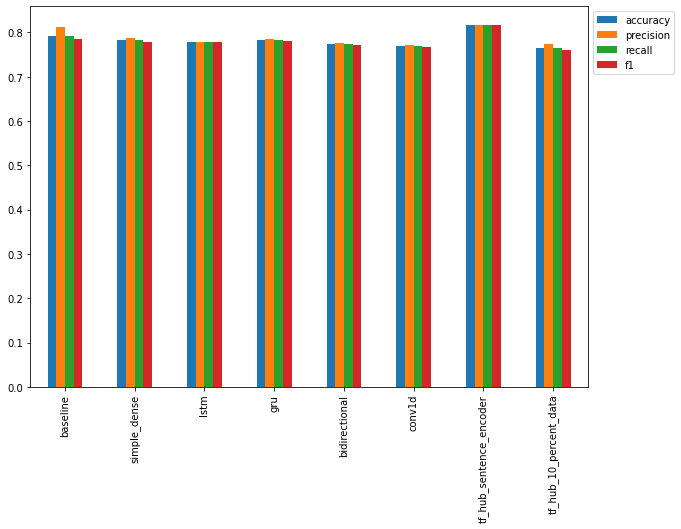

In [101]:
# Doğruluğu diğer metriklerle aynı ölçeğe indirin
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

Önceden eğitilmiş USE TensorFlow Hub modellerimiz en iyi performansa sahip gibi görünüyor, eğitim verilerinin yalnızca %10'una sahip olan model bile diğer modellerden daha iyi performans gösteriyor. Bu, transfer öğrenmenin gücünü gösterir.

Detaylara inip her modelin F1 puanlarını almaya ne dersiniz?

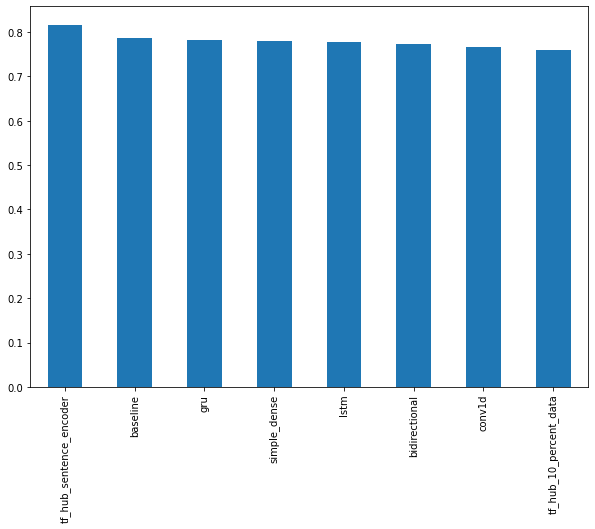

In [102]:
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

Tek bir ölçümde detaya indiğimizde, USE TensorFlow Hub modellerimizin diğer tüm modellerden daha iyi performans gösterdiğini görüyoruz. İlginç bir şekilde, temelin F1 puanı, daha derin modellerin geri kalanından çok uzakta değil.

## Modellerimizi Birleştirmek

Birçok üretim sistemi, bir tahmin yapmak için bir **ensemble** (birden çok farklı modelin bir araya getirilmesi) modellerini kullanır.

Model istiflemenin ardındaki fikir, birbiriyle ilişkisiz birkaç modelin bir tahmin üzerinde anlaşmaya varması durumunda, tahminin tekil bir model tarafından yapılan bir tahminden daha sağlam olması gerektiğidir.

Yukarıdaki cümledeki anahtar kelime ** uncorrelated**, bu da farklı model türleri demenin başka bir yoludur. Örneğin, bizim durumumuzda taban çizgimizi, çift yönlü modelimizi ve TensorFlow Hub USE modelimizi birleştirebiliriz.

Bu modellerin hepsi aynı veriler üzerinde eğitilmiş olsa da, hepsinin farklı bir kalıp bulma yolu vardır.

Üç LSTM modeli gibi benzer şekilde eğitilmiş üç model kullanacak olsaydık, çıktı tahminleri muhtemelen çok benzer olacaktır.

Bunu arkadaşlarınızla nerede yemek yiyeceğinize karar vermeye çalışmak olarak düşünün. Hepinizin zevkleri benzerse, muhtemelen hepiniz aynı restoranı seçeceksiniz. Ama hepinizin farklı zevkleri varsa ve yine de aynı restoranı seçerseniz, restoran iyi olmalı.

Bir sınıflandırma problemi ile çalıştığımız için modellerimizi birleştirmenin birkaç yolu vardır:
1. **Ortalama** - Her örnek için her modelin çıktı tahmin olasılıklarını alın, birleştirin ve ardından ortalamasını alın.
2. **Çoğunluk oyu (mod)** - Modellerinizin her biri ile tüm örneklerde sınıf tahminleri yapın, tahmin edilen sınıf çoğunlukta olandır. Örneğin, üç farklı model sırasıyla `[1, 0, 1]` değerini tahmin ederse, çoğunluk sınıfı `1` olur, bu nedenle bu tahmin edilen etiket olacaktır.
3. **Model yığınlama** - Seçtiğiniz modellerin her birinin çıktılarını alın ve bunları başka bir modele girdi olarak kullanın.

> 📖 **Kaynak:** Model istifleme/birleştirme için yukarıdaki yöntemler, Andriy Burkov tarafından [Machine Learning Engineering Book](http://www.mlebook.com/wiki/doku.php) Bölüm 6'dan uyarlanmıştır. Makine öğrenimi mühendisliği alanına girmek, yalnızca modeller oluşturmak değil, aynı zamanda üretim ölçeğinde makine öğrenimi sistemleri kurmak istiyorsanız, tamamını okumanızı şiddetle tavsiye ederim.

Yine, model istifleme kavramı en iyi eylemde görülür.

Temel modelimizi (`model_0`), LSTM modelimizi (`model_2`) ve tam eğitim verisi (`model_6`) üzerinde eğitilmiş USE modelimizi, her birinin birleşik tahmin olasılıklarının ortalamasını alarak birleştireceğiz.

In [107]:
# temel modelden tahmin olasılıklarını alın
baseline_pred_probs = np.max(model_0.predict_proba(val_sentences), axis=1)
combined_pred_probs = baseline_pred_probs + tf.squeeze(model_2_pred_probs, axis=1) + tf.squeeze(model_6_pred_probs)
# tahmin sınıfları için olasılıklarını ortalamasını alın ve yuvarlayın
combined_preds = tf.round(combined_pred_probs/3)
combined_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

Olağanüstü! Farklı sınıflardan oluşan birleştirilmiş bir tahminler dizimiz var, bunları gerçek etiketlere göre değerlendirelim ve yığılmış modelimizin sonuçlarını `all_model_results` DataFrame'imize ekleyelim.

In [108]:
ensemble_results = calculate_results(val_labels, combined_preds)
ensemble_results

{'accuracy': 77.95275590551181,
 'f1': 0.7799385559623664,
 'precision': 0.7827644591301087,
 'recall': 0.7795275590551181}

In [109]:
# Birleştirilmiş modelimizin sonuçlarını DataFrame sonuçlarına ekleyin
all_model_results.loc["ensemble_results"] = ensemble_results
# Doğruluğu, sonuçların geri kalanıyla aynı ölçeğe dönüştürün
all_model_results.loc["ensemble_results"]["accuracy"] = all_model_results.loc["ensemble_results"]["accuracy"]/100

all_model_results

,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
simple_dense,0.782152,0.786845,0.782152,0.779088
lstm,0.778215,0.778385,0.778215,0.778288
gru,0.783465,0.785557,0.783465,0.781439
bidirectional,0.774278,0.775989,0.774278,0.772231
conv1d,0.769029,0.770603,0.769029,0.766934
tf_hub_sentence_encoder,0.817585,0.817793,0.817585,0.816933
tf_hub_10_percent_data,0.765092,0.774665,0.765092,0.759687
ensemble_results,0.779528,0.782764,0.779528,0.779939


Yığılmış model diğer modellere karşı nasıl bir sonuç verdi?

> 🔑 **Not:** Modelimizin sonuçlarının çoğu benzer görünüyor. Bu, verilerimizden öğrenilebileceklerin bazı sınırlamaları olduğu anlamına gelebilir. Modelleme denemelerinizin çoğu benzer sonuçlar verdiğinde, verilerinizi tekrar gözden geçirmek iyi bir fikirdir.

## Eğitilmiş Bir Modeli Kaydetme ve Yükleme

Eğitim süresi çok uzun sürmese de, yeniden eğitmek zorunda kalmamak için eğitilmiş modellerinizi kaydetmek iyi bir uygulamadır.

Modellerinizi kaydetmek, aynı zamanda, bir web uygulamasında olduğu gibi, dizüstü bilgisayarınızın dışında başka bir yerde kullanmak üzere dışa aktarmanıza da olanak tanır.

[TensorFlow'da bir modeli kaydetmenin] iki ana yolu vardır(https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model):
1. `HDF5` biçimi.
2. `KayıtlıModel` biçimi (varsayılan).

İkisine de bir göz atalım.

In [110]:
model_6.save("model_6.h5")

Bir modeli `HDF5` olarak kaydederseniz, tekrar yüklerken TensorFlow'a kullandığınız özel nesneler hakkında bilgi vermeniz gerekir.

In [111]:
# Modeli özel Hub Katmanı ile yükleyin (HDF5 formatı için gereklidir)
loaded_model_6 = tf.keras.models.load_model(
    "model_6.h5", 
    custom_objects={"KerasLayer": hub.KerasLayer})

In [112]:
# Yüklenen modelimiz nasıl performans gösteriyor?
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 9ms/step - loss: 0.4258 - accuracy: 0.8176


[0.4257993996143341, 0.817585289478302]

Hedef modelimizde `save()` yöntemini çağırmak ve ona bir dosya yolu iletmek, modelimizi `SavedModel` formatında kaydetmemizi sağlar.

In [113]:
model_6.save("model_6_SavedModel_format")

INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets


INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets


SavedModel biçimini (varsayılan) kullanırsanız, `tensorflow.keras.models.load_model()` işlevini kullanarak özel nesneler belirtmeden modelinizi yeniden yükleyebilirsiniz.

In [114]:
# TF Hub Cümle Kodlayıcıyı Yükle SavedModel
loaded_model_6_SavedModel = tf.keras.models.load_model("model_6_SavedModel_format")

In [115]:
# Yüklenen SavedModel biçimini değerlendirin
loaded_model_6_SavedModel.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 10ms/step - loss: 0.4258 - accuracy: 0.8176


[0.4257993996143341, 0.817585289478302]

Gördüğünüz gibi, modelimizi her iki formatta da kaydedip yüklemek aynı performansı veriyor.

> 🤔 **Soru:** "KayıtlıModel" biçimini mi yoksa "HDF5" biçimini mi kullanmalısınız?

Çoğu kullanım durumu için `SavedModel` formatı yeterli olacaktır. Ancak bu, TensorFlow'a özel bir standarttır. Daha genel amaçlı bir veri standardına ihtiyacınız varsa, "HDF5" daha iyi olabilir.

## En Yanlış Örnekleri Bulma

Daha önce bahsetmiştik ki, modelleme deneylerimizin çoğu, farklı türde modeller kullanmamıza rağmen benzer sonuçlar veriyorsa, verilere geri dönüp bunun neden olabileceğini incelemenin iyi bir fikir olduğundan bahsetmiştik.

Verilerinizi incelemenin en iyi yollarından biri, modelinizin tahminlerini sıralamak ve onun en yanlış yaptığı örnekleri bulmaktır, yani hangi tahminlerin yüksek tahmin olasılığı vardı ama yanlış çıktı.

Bir kez daha, görselleştirme sizin arkadaşınızdır. Görselleştirin, görselleştirin, görselleştirin.

İşleri görsel hale getirmek için, en iyi performans gösteren modelimizin tahmin olasılıklarını ve sınıflarını doğrulama örnekleriyle (metin ve kesin doğruluk etiketleri) birlikte alalım ve bunları bir panda DataFrame'de birleştirelim.

* En iyi modelimiz hala mükemmel değilse, hangi örnekler yanlış gidiyor?
* Hangileri en yanlış?
* Yanlış olan bazı etiketler var mı? Örneğin. model doğru anlıyor ancak temel doğruluk etiketi bunu yansıtmıyor

In [118]:
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_preds,
                       "pred_prob": tf.squeeze(model_6_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.211150
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.824494
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.986701
3,@camilacabello97 Internally and externally scr...,1,0.0,0.232937
4,Radiation emergency #preparedness starts with ...,1,1.0,0.771707


Şimdi modelimizin yanlış tahminlerini bulalım (burada `target != pred`) ve bunları tahmin olasılıklarına göre sıralayalım (`pred_prob` sütunu).

In [119]:
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10]

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.933326
759,FedEx will no longer transport bioterror patho...,0,1.0,0.906695
628,@noah_anyname That's where the concentration c...,0,1.0,0.883666
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.878714
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.874096
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.868922
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.834798
144,The Sound of Arson,0,1.0,0.831975
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.826876
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.824494


Son olarak, örnek metni, doğruluk etiketini, tahmin sınıfını ve tahmin olasılığını görselleştirmek için bazı kodlar yazabiliriz. Örneklerimizi tahmin olasılığına göre sıraladığımız için, `en yanlış` DataFrame'imizin başındaki örneklere bakmak bize yanlış pozitifler gösterecektir.

Bir hatırlatıcı:
* `0` = Gerçek bir felaket Tweet değil
* `1` = Gerçek felaket Tweet

In [120]:
for row in most_wrong[:10].itertuples(): 
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1, Prob: 0.9333264827728271
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1, Prob: 0.9066951870918274
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1, Prob: 0.8836658596992493
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1, Prob: 0.878714382648468
Text:
@madonnamking RSPCA site multiple 7 story high rise buildings next to low density character residential in an area that floods

----

Target: 0, Pred: 1, Prob: 0.8740962147712708
Text:
[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES WITH MAGNE-TRACTION INSTRUCTIONS http://t.co/xEZBs3sq0y http://t.co/C2x0QoKGlY

----

Target: 0, Pred: 1, Prob: 0.8689219355583191
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

Target: 0, Pred: 1, Prob: 0.8347980976

In [121]:
# En yanlış yanlış negatifleri kontrol edin (model 1 tahmin etmeliyken 0 tahmin etti)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0, Prob: 0.07638642191886902
Text:
'The way you move is like a full on rainstorm and I'm a house of cards'

----

Target: 1, Pred: 0, Prob: 0.06680670380592346
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Pred: 0, Prob: 0.06613775342702866
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

----

Target: 1, Pred: 0, Prob: 0.06331083923578262
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0, Prob: 0.060991670936346054
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0, Prob: 0.04729391261935234
Text:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

----

Target: 1, Pred: 

En yanlış örneklerle ilgili ilginç bir şey fark ettiniz mi? Etiketler doğru mu? Geri dönüp olmayan etiketleri düzeltirsek ne olur sizce?

## Test Veri Seti Üzerinde Tahminler Yapmak

Pekala, modelimizin doğrulama setinde nasıl performans gösterdiğini gördük. Peki ya test veri seti?

Test veri seti için etiketlerimiz yok, bu yüzden bazı tahminler yapmamız ve bunları kendimiz incelememiz gerekecek. Test veri setinden rastgele örnekler üzerinde tahminler yapmak için bazı kodlar yazalım ve görselleştirelim.

In [126]:
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6.predict([test_sample]))
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("----\n")

Pred: 1, Prob: 0.5674287676811218
Text:
Marin Sr37 / Sr121 **Trfc Collision-Unkn Inj** http://t.co/yqJVEVhSzx

----

Pred: 0, Prob: 0.18044838309288025
Text:
Sometimes blood ain't no thicker than water and sometimes family will bring you down quicker than strangers ???????

----

Pred: 1, Prob: 0.9360947608947754
Text:
Agricultural Buildings on Fire - Aldwark - NYorks Fire &amp; Rescue Service 

Still grim news but fewer piglets caught up http://t.co/0kjCWG6pN9

----

Pred: 1, Prob: 0.936579704284668
Text:
See how a judge ruled in this 2009 accident at #JFK Airport? involving Korean Air?.

http://t.co/Yh1cGlN3rl http://t.co/6F5ShPKjOB

----

Pred: 0, Prob: 0.09350459277629852
Text:
@FollowerOfDole 'Give me your lunch money ner-' *flattened by falling quarter*

----

Pred: 0, Prob: 0.04109868034720421
Text:
100  1' MIX NEW FLAT DOUBLE SIDED LINERLESS BOTTLE CAPS YOU CHOOSE MIX FLATTENED - Full reÛ_ http://t.co/61fALvOCuK http://t.co/1MuTpFcgDL

----

Pred: 1, Prob: 0.6397950649261475
T

Modelinizin görünmeyen veriler üzerinde nasıl performans gösterdiğine ve ardından gerçek testte nasıl performans gösterebileceğine bir göz atmak için bu tür görselleştirme kontrollerini mümkün olduğunca sık yapmak önemlidir.

## Hız/Puan Dengesi

Yapacağımız son testlerden biri, en iyi modelimiz ve temel modelimiz arasındaki hız/puan dengelerini bulmaktır.

Bu neden önemli?

Deneme yoluyla bulduğunuz en iyi performans gösteren modeli seçmek cazip gelse de, bu model aslında bir üretim ortamında çalışmayabilir.

Bu şekilde ifade edin, Twitter olduğunuzu ve saatte 1 milyon Tweet aldığınızı hayal edin (bu uydurma bir sayıdır, gerçek sayı çok daha yüksektir). Ve Tweet'leri okumak ve bir felaketle ilgili ayrıntıları gerçek zamanlıya yakın bir şekilde yetkilileri uyarmak için bir felaket algılama sistemi oluşturmaya çalışıyorsunuz.

İşlem gücü ücretsiz değildir, bu nedenle proje için tek bir işlem makinesiyle sınırlısınız. Bu makinede, modellerinizden biri %80 doğrulukla saniyede 10.000 tahminde bulunurken, modellerinizden biri (daha büyük bir model) %85 doğrulukla saniyede 100 tahmin yapar.

Hangi modeli seçersiniz?

İkinci modelin performans artışı, ekstra kapasiteyi kaçırmaya değer mi? Tabii ki burada deneyebileceğiniz birçok seçenek var, ilk modele mümkün olduğunca çok Tweet göndermek ve ardından modelin en az emin olduğu şeyleri ikinci modele göndermek gibi.

Buradaki amaç, deney yoluyla bulduğunuz en iyi modeli göstermektir, üretimde kullandığınız model olmayabilir.

Bunu daha somut hale getirmek için, bir model ve bir dizi örnek alacak bir fonksiyon yazalım.

In [127]:
import time
def pred_timer(model, samples):
  start_time = time.perf_counter() 
  model.predict(samples) 
  end_time = time.perf_counter() 
  total_time = end_time-start_time 
  time_per_pred = total_time/len(val_sentences)
  return total_time, time_per_pred

İyi görünüyor!

Şimdi en iyi performans gösteren modelimizin (`model_6`) ve temel modelimizin (`model_0`) tahmin sürelerini değerlendirmek için `pred_timer()` fonksiyonumuzu kullanalım.

In [128]:
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6, val_sentences)
model_6_total_pred_time, model_6_time_per_pred

(0.22613020000062534, 0.00029675879265173927)

In [129]:
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.016506090001712437, 2.1661535435318158e-05)

Mevcut donanımımızla (benim durumumda bir Google Colab not defteri kullanıyorum) en iyi performans gösteren modelimiz, temel modelimiz olarak tahminler yapmak için 10 kat daha fazla zaman alıyor. Bu ekstra tahmin süresi buna değer mi?

Modelimizin F1 puanlarıyla tahmin başına süreyi karşılaştıralım.

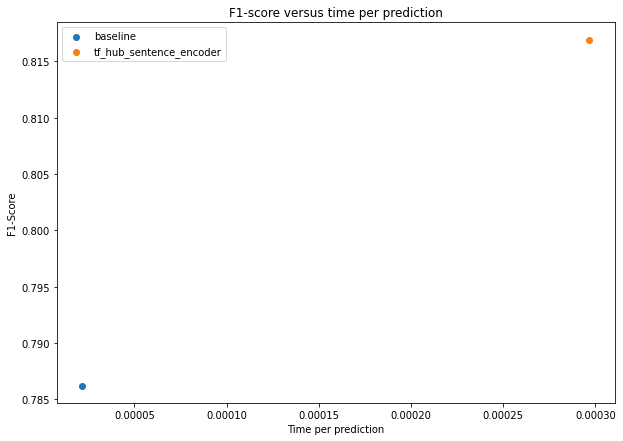

In [130]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-Score");

Elbette, bu noktaların her biri için ideal konum, grafiğin sol üst köşesinde olmaktır (tahmin başına düşük süre, yüksek F1 puanı).

Bizim durumumuzda, tahmin ve performans başına süre için açık bir fark var. En iyi performans gösteren modelimiz, tahmin başına bir büyüklük sırası daha uzun sürüyor, ancak yalnızca birkaç F1 puanı artışıyla sonuçlanıyor.

Bu tür bir fark, makine öğrenimi modellerini kendi uygulamalarınıza dahil ederken aklınızda bulundurmanız gereken bir şeydir.